In [1]:
import pygsti
import numpy as np
from matplotlib import pyplot as plt
import json
import pickle
import os
import pandas as pd

from helper import *

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/QPL/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Simulation notebook

This notebook simulates all of the circuits in a dataset. The first third of the notebook loads up or creates an error model. The second third simulates the random *i.i.d.*-layered circuits, and the final third simulates the random mirror circuits.

Select the dataset

In [58]:
exp_num = 4

Set your hyperparameters

In [59]:
typ = 'H'
exp_path = f'./experiment_{exp_num}'
sim_path = exp_path + '/simulation_results/'
circ_path = exp_path + '/circuits/'

try:
    os.makedirs(sim_path)
except:
    print('Blah')

with open('./experiment_0' + '/pspec.pkl', 'rb') as f:
    pspec = pickle.load(f)

max_stochastic = {'S': .0005, 'H': 0, 'H+S': .0001}
max_hamiltonian = {'S': 0, 'H': .00025, 'H+S': .0001}
max_strengths = {1: {'S': max_stochastic[typ], 'H': max_hamiltonian[typ]},
                 2: {'S': 3*max_stochastic[typ], 'H': 3*max_hamiltonian[typ]}
                 }


Construct the noise models or load an existing noise model

In [60]:
target_model = pygsti.models.create_crosstalk_free_model(processor_spec = pspec)

if exp_num == 0:
    error_rates_dict = sample_error_rates_dict(pspec, max_strengths)
    error_model = pygsti.models.create_crosstalk_free_model(pspec, lindblad_error_coeffs=error_rates_dict)

    with open(exp_path+'./error_rates.json', 'wb') as f:
        pickle.dump({'gate-errors': error_rates_dict}, 
                 f)

    with open(exp_path + '/error_model.pkl', 'wb') as f:
        pickle.dump(error_model, f)
else:
    with open('./experiment_0' + '/error_model.pkl', 'rb') as f:
        error_model = pickle.load(f)

# Simulate the random *i.i.d.*-layered circuits

In [61]:
%%time

circuits = pygsti.io.read_circuit_list(circ_path + '/iid_layer_random_clifford_circuits_v1_instance_0.txt')
good_circuits = []
for c in circuits:
    new_c = c.copy(editable = True)
    # new_c.map_state_space_labels_inplace({0: 'Q0', 1: 'Q1', 2: 'Q2', 3: 'Q3'})
    new_c.done_editing()
    good_circuits.append(new_c)

CPU times: user 1.76 s, sys: 10.7 ms, total: 1.77 s
Wall time: 1.77 s


In [62]:
%%time
fids = []
for i, c in enumerate(good_circuits):
    #print(i, '(', (c.depth), ')', end=',')
    if i % 100 == 0:
        print(i, '(', (c.depth), ')', end=',')
    pmatrix = error_model.circuit_operator(c).to_dense()
    target_pmatrix = target_model.circuit_operator(c).to_dense()
    fids.append(pygsti.entanglement_fidelity(pmatrix, target_pmatrix))

0 ( 29 ),100 ( 19 ),200 ( 34 ),300 ( 167 ),400 ( 1 ),500 ( 30 ),600 ( 3 ),700 ( 5 ),800 ( 24 ),900 ( 13 ),1000 ( 5 ),1100 ( 12 ),1200 ( 44 ),1300 ( 14 ),1400 ( 69 ),1500 ( 6 ),1600 ( 19 ),1700 ( 6 ),1800 ( 94 ),1900 ( 21 ),2000 ( 8 ),2100 ( 19 ),2200 ( 39 ),2300 ( 9 ),2400 ( 143 ),2500 ( 6 ),2600 ( 180 ),2700 ( 22 ),2800 ( 26 ),2900 ( 26 ),3000 ( 19 ),3100 ( 30 ),3200 ( 1 ),3300 ( 13 ),3400 ( 28 ),3500 ( 21 ),3600 ( 20 ),3700 ( 7 ),3800 ( 14 ),3900 ( 17 ),4000 ( 16 ),4100 ( 3 ),4200 ( 127 ),4300 ( 5 ),4400 ( 14 ),4500 ( 14 ),4600 ( 4 ),4700 ( 11 ),4800 ( 1 ),4900 ( 178 ),CPU times: user 1h 39s, sys: 56.9 s, total: 1h 1min 36s
Wall time: 10min 22s


Visualize the distribution of fidelities.

(array([1.000e+00, 3.000e+00, 4.000e+00, 1.300e+01, 1.700e+01, 4.100e+01,
        1.320e+02, 3.990e+02, 1.433e+03, 2.957e+03]),
 array([0.88503467, 0.8965275 , 0.90802034, 0.91951318, 0.93100601,
        0.94249885, 0.95399169, 0.96548452, 0.97697736, 0.9884702 ,
        0.99996303]),
 <BarContainer object of 10 artists>)

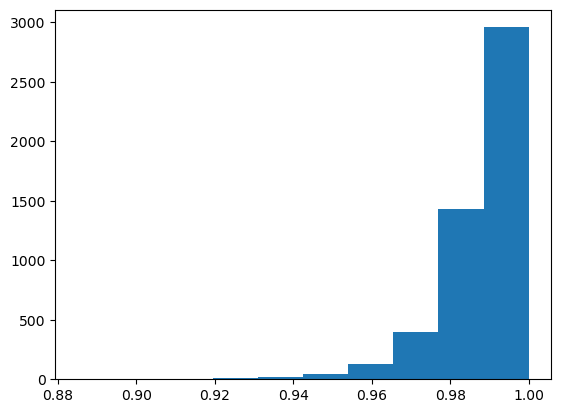

In [63]:
plt.hist(fids)

# Save the fidelites (as a json and a dataframe)

In [64]:
### As a json ###

with open(sim_path+'/fidelities.json', 'w') as f:
    json.dump(fids, f)


In [65]:
### As a dataframe ###

def create_dataframe(circs, fidelities):
    dfdict = {'Circuit': [],
                'D:SP': [],
                'F:Depth': [],
                'F:Width': [],
                'F:2QGC': []
                }

    for circ, fid in zip(circs, fidelities):
        dfdict['Circuit'].append(circ.str)
        dfdict['F:Width'].append(circ.width)
        dfdict['F:Depth'].append(circ.depth)
        dfdict['F:2QGC'].append(circ.two_q_gate_count())
        dfdict['D:SP'].append(fid)

    df = pd.DataFrame(dfdict)
    return df
df = create_dataframe(good_circuits, fids)
df.drop_duplicates(subset='Circuit', keep='first', inplace=True) # drop any unnecesarry duplicates
df.reset_index(drop=True, inplace=True)

df.to_csv(sim_path+'/dataframe.csv', index = False)

# Simulate the mirror circuits (if you have them)

Fill in.

In [66]:
with open('./experiment_0/error_model.pkl', 'rb') as f:
    error_model = pickle.load(f)

df_old = pd.read_csv(sim_path + '/dataframe.csv')
max_depth = max(df_old['F:Depth'])

In [67]:
%%time
other_circuits = pygsti.io.read_circuit_list(circ_path + '/mirrored_random_clifford_circuits_v1_instance_0.txt')
good_other_circuits = []
for c in other_circuits:
    new_c = c.copy(editable = True)
    # new_c.map_state_space_labels_inplace({0: 'Q0', 1: 'Q1', 2: 'Q2', 3: 'Q3'})
    new_c.done_editing()
    good_other_circuits.append(new_c)

CPU times: user 612 ms, sys: 4.83 ms, total: 617 ms
Wall time: 660 ms


0 ( 172 ),100 ( 113 ),200 ( 158 ),300 ( 93 ),400 ( 124 ),500 ( 109 ),600 ( 133 ),700 ( 143 ),CPU times: user 25min 6s, sys: 20.3 s, total: 25min 27s
Wall time: 4min 15s


(array([  5.,  13.,  19.,  31.,  48.,  59.,  81., 118., 155., 221.]),
 array([0.87303486, 0.88571747, 0.89840007, 0.91108268, 0.92376528,
        0.93644789, 0.94913049, 0.9618131 , 0.9744957 , 0.98717831,
        0.99986091]),
 <BarContainer object of 10 artists>)

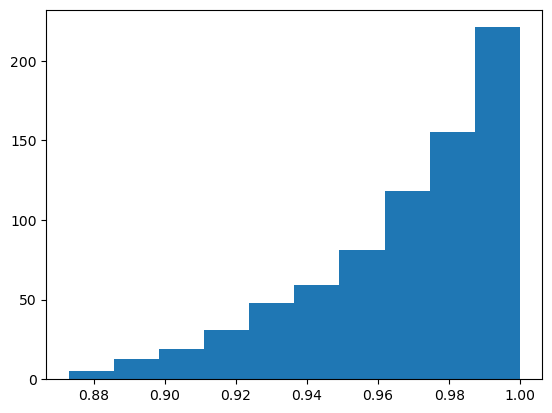

In [68]:
%%time
other_fids = []
for i, c in enumerate(good_other_circuits):
    #print(i, '(', (c.depth), ')', end=',')
    if i % 100 == 0:
        print(i, '(', (c.depth), ')', end=',')
    pmatrix = error_model.circuit_operator(c).to_dense()
    target_pmatrix = target_model.circuit_operator(c).to_dense()
    other_fids.append(pygsti.entanglement_fidelity(pmatrix, target_pmatrix))
plt.hist(other_fids)

In [69]:
def create_dataframe(circs, fidelities):
    dfdict = {'Circuit': [],
                'D:SP': [],
                'F:Depth': [],
                'F:Width': [],
                'F:2QGC': []
                }

    for circ, fid in zip(circs, fidelities):
        dfdict['Circuit'].append(circ.str)
        dfdict['F:Width'].append(circ.width)
        dfdict['F:Depth'].append(circ.depth)
        dfdict['F:2QGC'].append(circ.two_q_gate_count())
        dfdict['D:SP'].append(fid)

    df = pd.DataFrame(dfdict)
    return df
df_other = create_dataframe(good_other_circuits, other_fids)
df_other.drop_duplicates(subset='Circuit', keep='first', inplace=True) # drop any unnecesarry duplicates
df_other = df_other[df_other['F:Depth'] <= max_depth]
good_other_circ_indices = np.array(df_other.index)

In [70]:
# get rid of the circuits that are too long

good_other_fids = np.array(other_fids)
good_other_fids = good_other_fids[good_other_circ_indices]
good_other_fids = list(good_other_fids)

In [71]:
with open(sim_path+'/mirrored_fidelities.json', 'w') as f:
    json.dump(good_other_fids, f)

In [72]:
df_other.reset_index(drop=True, inplace=True)
df_other.to_csv(sim_path+'/mirrored_dataframe.csv', index = False)